<a href="https://colab.research.google.com/github/mkkim007/AIFFEL/blob/main/%5BE_03%5DStickerCamera.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [E-03] 카메라 스티커앱 만들기



패키지 설치

In [ ]:
'''
!pip install opencv-python
!pip install cmake
!pip install dlib
'''

import module

In [65]:
import cv2                          # openCV - 이미지 처리
import matplotlib.pyplot as plt     # 이미지 출력
import numpy as np                  # 
import dlib                         # 얼굴검출
import math

## 1.사진 준비하기

###1.1 구글 드라이브 연동

먼저 구글 드라이브에 연동을 해서 사진을 가지고 오겠습니다. 

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


`model` 폴더와 `image`폴더를 만들어 줍니다.

In [3]:
!mkdir -p camera_sticker/models
!mkdir -p camera_sticker/images

구글 드라이브에 있는 사진들을 `images` 폴더에 copy 해줍니다.

In [4]:
!cp /content/gdrive/MyDrive/Data/image.png camera_sticker/images
!cp /content/gdrive/MyDrive/Data/cat-whiskers.png camera_sticker/images

### 1.2. 이미지 로드

이제 본격적으로 준비한 이미지를 불러옵니다.  
이미지 파일을 읽어 올 때는 `cv.imread()` 함수를 이용합니다.  
> #### cv.imread(fileName, flag)
- fileName : 이미지 파일의 경로
- flag : 이미지 파일을 읽을 때 option
    1. `cv2.IMREAD_COLOR`(1) : 이미지 파일을 Color로 읽어들임. 투명한 부분은 무시되며, Default값
    2. `cv2.IMREAD_GRAYSCALE`(0) : 이미지를 Grayscale로 읽어 들임. 실제 이미지 처리시 중간단계로 많이 사용.
    3. `cv2.IMREAD_UNCHANGED`(-1) : 이미지파일을 alpha channel까지 포함하여 읽어 들임.

[출처 - 이미지 다루기](https://opencv-python.readthedocs.io/en/latest/doc/01.imageStart/imageStart.html)


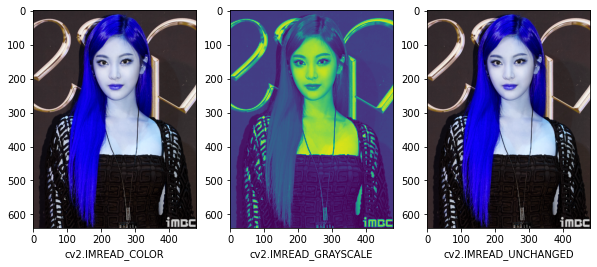

In [20]:
my_image_path = '/content/camera_sticker/images/image.png'
img_bgr_clolor = cv2.imread(my_image_path)                              # flag : 1
img_bgr_clolor = cv2.resize(img_bgr_clolor, (480,640))                  # 480X640 의 크기로 Resize

img_bgr_grayscale = cv2.imread(my_image_path, cv2.IMREAD_GRAYSCALE)     # flag : 0
img_bgr_grayscale = cv2.resize(img_bgr_grayscale, (480,640))            # 480X640 의 크기로 Resize

img_bgr_unchanged = cv2.imread(my_image_path, cv2.IMREAD_UNCHANGED)     # flag : -1
img_bgr_unchanged = cv2.resize(img_bgr_unchanged, (480,640))            # 480X640 의 크기로 Resize
img_show = img_bgr_clolor.copy()            # 출력용 이미지 별도 보관

fig = plt.figure()
ax1 = fig.add_subplot(1,3,1)
ax1.imshow(img_bgr_clolor)
ax1.set_xlabel('cv2.IMREAD_COLOR')

ax2 = fig.add_subplot(1,3,2)
ax2.imshow(img_bgr_grayscale)
ax2.set_xlabel('cv2.IMREAD_GRAYSCALE')

ax3 = fig.add_subplot(1,3,3)
ax3.imshow(img_bgr_unchanged)
ax3.set_xlabel('cv2.IMREAD_UNCHANGED')

plt.rcParams["figure.figsize"] = (10,4)     #사이즈 조절
plt.show()

뭔가 색감이 이상하게 나옵니다  왜 그럴까요?  
웬만한 이미지 라이브러리(ex.matplotlib)는 이미지 채널을 **RGB(빨강, 녹색, 파랑)** 순으로 사용합니다.  
그러나 `opencv`는 이미지 채널을 **BGR(파랑, 녹색, 빨강)**을 사용합니다.   
그래서 `plt.imshow` 사용하기전에 `CV2.cvtColor`를 사용해 RGB 이미지로 꼭 바꿔줘야 합니다.

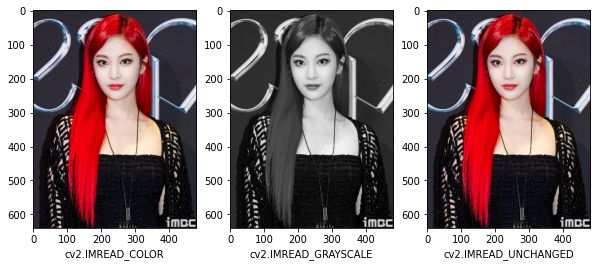

In [21]:
img_rgb = cv2.cvtColor(img_bgr_clolor, cv2.COLOR_BGR2RGB)
img_rgb_grayscale = cv2.cvtColor(img_bgr_grayscale, cv2.COLOR_BGR2RGB)
img_rgb_unchanged = cv2.cvtColor(img_bgr_unchanged, cv2.COLOR_BGR2RGB)


fig = plt.figure()
ax1 = fig.add_subplot(1,3,1)
ax1.imshow(img_rgb)
ax1.set_xlabel('cv2.IMREAD_COLOR')

ax2 = fig.add_subplot(1,3,2)
ax2.imshow(img_rgb_grayscale)
ax2.set_xlabel('cv2.IMREAD_GRAYSCALE')

ax3 = fig.add_subplot(1,3,3)
ax3.imshow(img_rgb_unchanged)
ax3.set_xlabel('cv2.IMREAD_UNCHANGED')

plt.rcParams["figure.figsize"] = (10,4)     #사이즈 조절
plt.show()

## 2.얼굴 검출

우리는 얼굴 검출을 위해서 `dlib`패키지를 사용합니다.  
`dlib` 의 face detector는 __HOG__(Histogram of Oriented Gradient) feature를 사용해서 __SVM__(Support Vector Machine)의 sliding window로 얼굴을 찾습니다.  

자세한 알고리즘은 아래의 링크에 있습니다.  

[기계 학습은 즐겁다! Part4](https://medium.com/@jongdae.lim/%EA%B8%B0%EA%B3%84-%ED%95%99%EC%8A%B5-machine-learning-%EC%9D%80-%EC%A6%90%EA%B2%81%EB%8B%A4-part-4-63ed781eee3c) 



In [32]:
detector_hog = dlib.get_frontal_face_detector()   # detector 선언

In [33]:
img_rgb = cv2.cvtColor(img_bgr_clolor, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   # detector_hog(image, num of img pyramid)

rectangles[[(167, 116) (322, 270)]]


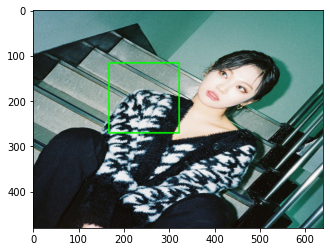

In [34]:
print(dlib_rects)   # 찾은 얼굴영역 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

## 3.얼굴 랜드마크

In [46]:
!wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
!mv shape_predictor_68_face_landmarks.dat.bz2 camera_sticker/models
!cd camera_sticker/models && bzip2 -d shape_predictor_68_face_landmarks.dat.bz2

--2021-07-25 15:46:51--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2’

shape_predictor_68_ 100%[===================>]  61.07M  26.5MB/s    in 2.3s    

2021-07-25 15:46:54 (26.5 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2’ saved [64040097/64040097]



In [47]:
model_path = 'camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)
print("🌫🛸")

🌫🛸


In [ ]:
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


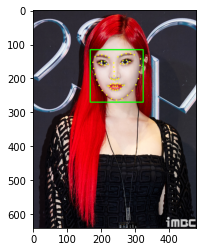

In [ ]:
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

## 4. 스티커 적용하기

In [ ]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # nose center index : 30
    x = landmark[30][0]
    y = (landmark[2][1]+landmark[36][1]+landmark[48][1])//3
    w = dlib_rect.width()
    h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(237, 193)
(x,y) : (237,188)
(w,h) : (156,156)


In [ ]:
sticker_path = '/content/camera_sticker/images/cat-whiskers.png'

img_sticker = cv2.imread(sticker_path)
print (img_sticker.shape)
img_sticker = cv2.resize(img_sticker, (w,h))

print (img_sticker.shape)

(512, 512, 3)
(156, 156, 3)


In [ ]:
refined_x = x - w // 2  # left
refined_y = y - h // 2 # top
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (159,110)


In [ ]:
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:]
    refined_y = 0
print (img_sticker.shape)
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(156, 156, 3)
(x,y) : (159,110)


In [ ]:
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

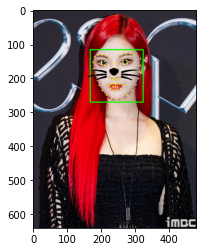

In [ ]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

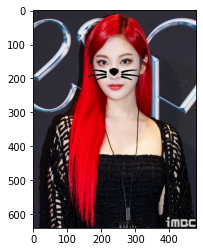

In [ ]:
sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
cv2.getRotationMatrix2D 
math.atan(h/w)/math.pi*180

In [ ]:
rotated_image = cv2.warpAffine(img, M, (cols, rows), borderValue=(255,255,255))

벡터 흰색으로 채우는 
border_transparent 벡터 투명색

돌아가있는 사진

In [39]:
!cp /content/gdrive/MyDrive/Data/side.jpg camera_sticker/images

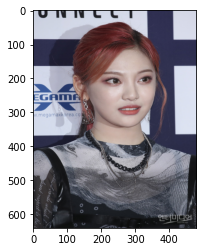

rectangles[[(180, 139) (366, 325)]]


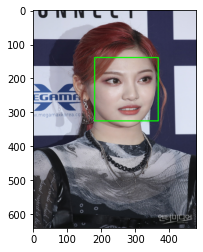

68


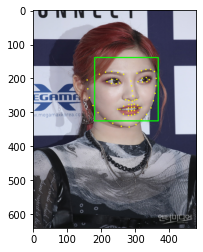

In [83]:
my_image_path = '/content/camera_sticker/images/side.jpg'
img_rotation = cv2.imread(my_image_path)   
img_rotation = cv2.resize(img_rotation, (480, 640))    
img_show = img_rotation.copy()     
plt.imshow(cv2.cvtColor(img_rotation, cv2.COLOR_BGR2RGB))
plt.show()
detector_hog = dlib.get_frontal_face_detector()   # detector 선언
dlib_rects = detector_hog(img_rotation, 1)   # detector_hog(image, num of img pyramid)
print(dlib_rects)   # 찾은 얼굴영역 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rotation, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

(292, 252)
(x,y) : (292,252)
(w,h) : (187,187)
(512, 512, 3)
(187, 187, 3)
(x,y) : (199,159)
(187, 187, 3)
(x,y) : (199,159)


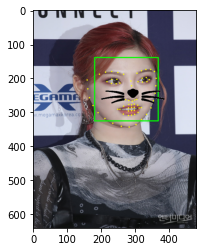

In [84]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # nose center index : 30
    x = landmark[30][0]
    y = (landmark[2][1]+landmark[36][1]+landmark[48][1])//3
    w = dlib_rect.width()
    h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

sticker_path = '/content/camera_sticker/images/cat-whiskers.png'

img_sticker = cv2.imread(sticker_path)
print (img_sticker.shape)
img_sticker = cv2.resize(img_sticker, (w,h))

print (img_sticker.shape)

refined_x = x - w // 2  # left
refined_y = y - h // 2 # top
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

if refined_y < 0:
    img_sticker = img_sticker[-refined_y:]
    refined_y = 0
print (img_sticker.shape)
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

In [78]:
!cp /content/gdrive/MyDrive/Data/side2.jpg camera_sticker/images

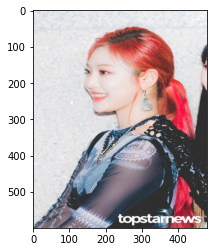

rectangles[[(98, 116) (253, 270)]]


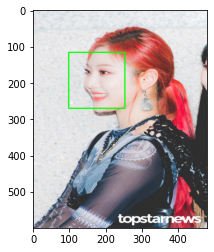

In [86]:
my_image_path = '/content/camera_sticker/images/side2.jpg'
img_rotation = cv2.imread(my_image_path)   
img_rotation = cv2.resize(img_rotation, (480, 600))    
img_show = img_rotation.copy()     
plt.imshow(cv2.cvtColor(img_rotation, cv2.COLOR_BGR2RGB))
plt.show()
detector_hog = dlib.get_frontal_face_detector()   # detector 선언
dlib_rects = detector_hog(img_rotation, 1)   # detector_hog(image, num of img pyramid)
print(dlib_rects)   # 찾은 얼굴영역 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

68


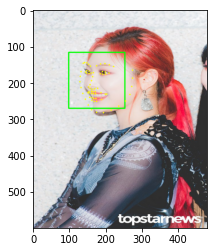

(157, 205)
(x,y) : (157,198)
(w,h) : (156,156)
(512, 512, 3)
(156, 156, 3)
(x,y) : (79,120)
(156, 156, 3)
(x,y) : (79,120)


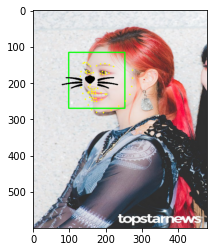

In [87]:
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rotation, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # nose center index : 30
    x = landmark[30][0]
    y = (landmark[2][1]+landmark[36][1]+landmark[48][1])//3
    w = dlib_rect.width()
    h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

sticker_path = '/content/camera_sticker/images/cat-whiskers.png'

img_sticker = cv2.imread(sticker_path)
print (img_sticker.shape)
img_sticker = cv2.resize(img_sticker, (w,h))

print (img_sticker.shape)

refined_x = x - w // 2  # left
refined_y = y - h // 2 # top
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

if refined_y < 0:
    img_sticker = img_sticker[-refined_y:]
    refined_y = 0
print (img_sticker.shape)
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

In [56]:
!cp /content/gdrive/MyDrive/Data/rotation2.jpg camera_sticker/images

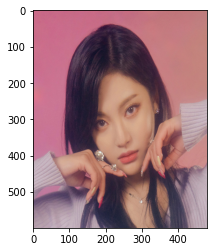

rectangles[[(159, 242) (345, 428)]]


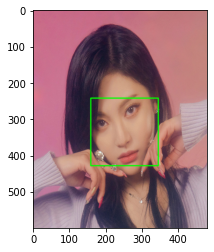

In [75]:
my_image_path = '/content/camera_sticker/images/rotation2.jpg'
img_rotation = cv2.imread(my_image_path)   
img_rotation = cv2.resize(img_rotation, (480, 600))    
img_show = img_rotation.copy()     
plt.imshow(cv2.cvtColor(img_rotation, cv2.COLOR_BGR2RGB))
plt.show()
detector_hog = dlib.get_frontal_face_detector()   # detector 선언
dlib_rects = detector_hog(img_rotation, 1)   # detector_hog(image, num of img pyramid)
print(dlib_rects)   # 찾은 얼굴영역 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

68


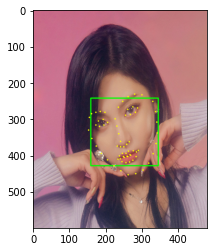

In [76]:
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rotation, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()



(241, 361)
(x,y) : (241,366)
(w,h) : (187,187)
(512, 512, 3)
(187, 187, 3)
(x,y) : (148,273)
(187, 187, 3)
(x,y) : (148,273)


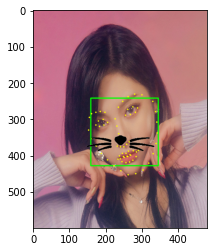

In [74]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # nose center index : 30
    x = landmark[30][0]
    y = (landmark[2][1]+landmark[36][1]+landmark[48][1])//3
    w = dlib_rect.width()
    h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

sticker_path = '/content/camera_sticker/images/cat-whiskers.png'

img_sticker = cv2.imread(sticker_path)
print (img_sticker.shape)
img_sticker = cv2.resize(img_sticker, (w,h))

print (img_sticker.shape)


refined_x = x - w // 2  # left
refined_y = y - h // 2 # top
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:]
    refined_y = 0
print (img_sticker.shape)
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

(241, 361)
(512, 512, 3)
(x,y) : (148,273)
(187, 187, 3)
(x,y) : (148,273)


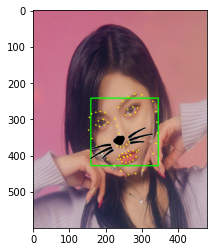

In [77]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # nose center index : 30
    
    x = landmark[30][0]
    y = (landmark[2][1]+landmark[36][1]+landmark[48][1])//3
    x1 = landmark[2][0]
    x2 = landmark[14][0]
    y1 = landmark[2][1]
    y2 = landmark[14][1]
    w = dlib_rect.width()
    h = dlib_rect.width()



sticker_path = '/content/camera_sticker/images/cat-whiskers.png'

img_sticker = cv2.imread(sticker_path)
print (img_sticker.shape)
img_sticker = cv2.resize(img_sticker, (w,h))

angle = math.atan((abs(y2-y1))/(abs(x2-x1)))/math.pi*180
matrix = cv2.getRotationMatrix2D((w/2, h/2), angle, 1)
img_sticker_rotation = cv2.warpAffine(img_sticker, matrix, (w, h),borderValue=(255,255,255))

refined_x = x - w // 2  # left
refined_y = y - h // 2 # top
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))
if refined_y < 0:
    img_sticker_rotation = img_sticker_rotation[-refined_y:]
    refined_y = 0
print (img_sticker_rotation.shape)
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))
sticker_area = img_show[refined_y:refined_y+img_sticker_rotation.shape[0], refined_x:refined_x+img_sticker_rotation.shape[1]]
img_show[refined_y:refined_y+img_sticker_rotation.shape[0], refined_x:refined_x+img_sticker_rotation.shape[1]] = \
    np.where(img_sticker_rotation==255,sticker_area,img_sticker_rotation).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

In [25]:
!cp /content/gdrive/MyDrive/Data/rotation.jpg camera_sticker/images

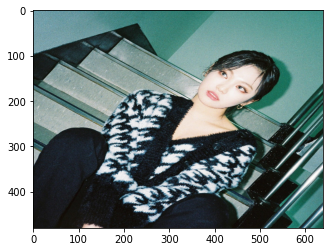

In [37]:
my_image_path = '/content/camera_sticker/images/rotation.jpg'
img_rotation = cv2.imread(my_image_path)   
img_rotation = cv2.resize(img_rotation, (640, 480))    
img_show = img_rotation.copy()     
plt.imshow(cv2.cvtColor(img_rotation, cv2.COLOR_BGR2RGB))
plt.show()

rectangles[]


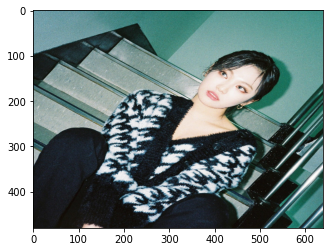

In [38]:
detector_hog = dlib.get_frontal_face_detector()   # detector 선언
dlib_rects = detector_hog(img_rotation, 1)   # detector_hog(image, num of img pyramid)
print(dlib_rects)   # 찾은 얼굴영역 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

# 🤔회고록🤔
- 기존에 있는 데이터 중에서 test를 하면 90%가 넘었지만 모델이 전혀 보지 못한 데이터들은 60%를 넘기는 것이 생각보다 너무 어려웠다.